## Import Packages

In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
from datetime import datetime
import spacy as sp
from spacy.matcher import PhraseMatcher, Matcher
from collections import Counter

import os

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Preprocessing

In [118]:
data = pd.read_csv('r_wallstreetbets_posts.csv')

/Users/dani/.conda/envs/ADA-wallstreetbets-project/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [119]:
# load tickers
import requests # allows for file downloading
import os

filename = 'ticker.txt'
url = 'https://www.sec.gov/include/ticker.txt'
if os.path.exists(filename):
    print(f'{filename} already downloaded')
else:
    r = requests.get(url, allow_redirects=True)
    with open(filename, 'wb') as file:
        file.write(r.content)
    print(f'{filename} has been downloaded')


ticker.txt already downloaded


In [120]:
# put tickers into dataframe
tickers = pd.read_csv('ticker.txt', delimiter = "\t", header=None)
tickers.columns = ['symbol', 'code']

# Note: some tickers are the same as common words or letters such as NAN, K, AND
tickers['symbol'] = tickers['symbol'].str.upper() 
print(tickers.iloc[4101])

# dropping 'NAN' North American Nickel ticker for now
tickers = tickers.dropna()
print(tickers.isnull().values.any())
#GME_data = yf.Ticker("GME")
tickers.head(5)

symbol       HMTV
code      1567345
Name: 4101, dtype: object
False


,symbol,code
0,AAPL,320193
1,MSFT,789019
2,AMZN,1018724
3,GOOG,1652044
4,FB,1326801


In [121]:
data.columns

Index(['id', 'title', 'score', 'author', 'author_flair_text', 'removed_by',
       'total_awards_received', 'awarders', 'created_utc', 'full_link',
       'num_comments', 'over_18'],
      dtype='object')

In [122]:
data = data.drop(columns = ['awarders', 'over_18', 'author_flair_text', 'removed_by','full_link','author'])

In [123]:
print(data.columns)
print(data.shape)

# analysis of date and scores
max_date, min_date = datetime.fromtimestamp(max(data.created_utc)), datetime.fromtimestamp(min(data.created_utc))
print('date ranges: ', min_date, max_date)
print('score range ', max(data.score), min(data.score))
print('num comments range ', max(data.num_comments), min(data.num_comments))

# find score and comments distributions
no_score_data = data[data.score==0]
low_score_data =data[data.score<= 100]
mid_score_data = data[(data.score <= 1000) & (data.score > 100)]
high_score_data = data[data.score > 1000]
print('scores: ', len(no_score_data), len(low_score_data), len(mid_score_data), len(high_score_data))
print('avg score: ', np.mean(data.score.values), 'std score: ', np.std(data.score.values))

Index(['id', 'title', 'score', 'total_awards_received', 'created_utc',
       'num_comments'],
      dtype='object')
(1118863, 6)
date ranges:  2012-04-11 18:40:40 2021-02-16 10:53:12
score range  134840 0
num comments range  204551 0
scores:  43920 1098686 17150 3027
avg score:  27.080198379962514 std score:  746.7225959766157


In [124]:
# keep posts with score > 100 or num comments > 100 or total awards > 10
# determine best threshold for keeping posts
df = data[(data.score >= 100) | (data.num_comments >= 50) | (data.total_awards_received >= 10)] 
print('comments avg and std: ', df.num_comments.mean(), df.num_comments.std())
print(df.shape)

comments avg and std:  496.93440145102784 3791.780930431671
(59544, 6)


## Vader Sentiment Scores

In [125]:
# Calculate polarity scores
sia = SIA()
# baseline compound is pos if >= 0.05, neg if <= -0.05 and neu else
# change baseline to 0 for binary classification
def calculate_sentiment(text):
    pol_score = sia.polarity_scores(text)
    if pol_score['compound'] >= 0.05:
        return 1
    elif pol_score['compound'] <= -0.05:
        return -1
    else:
        return 0

In [126]:
# add sentiment and compound col to df
df['sentiment'] = df.apply(lambda x: calculate_sentiment(x.title), axis=1)
df['compound'] = df.apply(lambda x: sia.polarity_scores(x.title)['compound'], axis=1)
df.head(3)

<ipython-input-126-ca18aa37ea92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df.apply(lambda x: calculate_sentiment(x.title), axis=1)
<ipython-input-126-ca18aa37ea92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound'] = df.apply(lambda x: sia.polarity_scores(x.title)['compound'], axis=1)


,id,title,score,total_awards_received,created_utc,num_comments,sentiment,compound
92,lkzviy,I am going to short the whole country of South...,1,0.0,1613465649,114,0,0.0000
185,lkyw58,I like the stonk,1,0.0,1613461282,50,1,0.3612
256,lky7u6,When you realize losing your hard earned money...,1,0.0,1613458484,73,-1,-0.4588


In [127]:
df

,id,title,score,total_awards_received,created_utc,num_comments,sentiment,compound
92,lkzviy,I am going to short the whole country of South...,1,0.0,1613465649,114,0,0.0000
185,lkyw58,I like the stonk,1,0.0,1613461282,50,1,0.3612
256,lky7u6,When you realize losing your hard earned money...,1,0.0,1613458484,73,-1,-0.4588
261,lky552,Hiding shorts by ETF's?,1,0.0,1613458201,139,-1,-0.2960
486,lkwazx,Dwight Schrute owns Palantir,1,0.0,1613451488,58,0,0.0000
...,...,...,...,...,...,...,...,...
1118419,ykbw8,Let's play a game. Find banned and/or censore...,4,NaN,1345522913,50,-1,-0.2960
1118425,ydook,"Well, once again I'm out of the game for a whi...",20,NaN,1345216708,54,1,0.5854
1118463,xn13d,I'm out fellas (explanation inside).,0,NaN,1344027787,51,0,0.0000
1118512,wnunt,[VVUS/ARNA/OREX] July 17 obesity thread,13,NaN,1342470600,51,0,0.0000


In [128]:
# counting sentiments 
sentiments = [-1, 0, 1]
sentiments_count = [sum(df.sentiment == -1), sum(df.sentiment == 0), sum(df.sentiment == 1)]
df.sentiment.value_counts()

 0    31449
 1    15491
-1    12604
Name: sentiment, dtype: int64

## TextBlob Sentiment Scores

In [129]:
# Calculating TextBlob Scores

from textblob import TextBlob

def calculate_sentiment_tb(text,compound=True):
    '''
    text: string input
    compound: if true, return compound score. Otherwise return -1, 0, or 1
    
    '''
    blob = TextBlob(text)
    
    if compound: 
        return blob.polarity
    
    else: 
        if blob.polarity >= 0.05:
            return 1
        elif blob.polarity <= -0.05:
            return -1
        else:
            return 0
        
df['tb_sentiment'] = df.apply(lambda x: calculate_sentiment_tb(x.title), axis=1)

<ipython-input-129-04b1722d9803>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tb_sentiment'] = df.apply(lambda x: calculate_sentiment_tb(x.title), axis=1)


In [130]:
df.head(3)

,id,title,score,total_awards_received,created_utc,num_comments,sentiment,compound,tb_sentiment
92,lkzviy,I am going to short the whole country of South...,1,0.0,1613465649,114,0,0.0000,0.100000
185,lkyw58,I like the stonk,1,0.0,1613461282,50,1,0.3612,0.000000
256,lky7u6,When you realize losing your hard earned money...,1,0.0,1613458484,73,-1,-0.4588,-0.395833


## Finding Stock Tickers in Posts

In [131]:
# stocks to find,
stocks = [ 'GME']
company_names = {'GAMESTOP': 'GME' }

In [132]:
# pattern matching with most frequent stocks 
nlp_freq = sp.blank('en')
matcher_freq = PhraseMatcher(nlp_freq.vocab, attr='TEXT')
freq_token_list = [nlp_freq(item) for item in stocks + list(company_names)]
matcher_freq.add('Freq Stocks', freq_token_list)

In [133]:
# find tickers and company names only from specified list
def find_tickers_and_names(title):
    doc = nlp_freq(title.upper())
    matches = matcher_freq(doc)
    found_items = set([str(doc[match[1]: match[2]]).replace(' ', '') for match in matches])
    tickers_list = set()
    for item in found_items:
        if item in company_names:
            tickers_list.add(company_names[item])
        else:
            tickers_list.add(item)
    for ticker in tickers_list:
        ticker_freq[ticker] += 1
    return '_'.join(tickers_list)

In [134]:
ticker_freq = Counter()
df['orgs'] = df.apply(lambda x: find_tickers_and_names(x.title), axis=1)
print(ticker_freq, sum(ticker_freq.values()))

Counter({'GME': 3685}) 3685


<ipython-input-134-1eed1b2185c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['orgs'] = df.apply(lambda x: find_tickers_and_names(x.title), axis=1)


In [135]:
# create new dataframe for only posts with specific organizations mentioned
df_stocks = df[df.orgs != '']
print(df_stocks.shape)
df_stocks.head()

(3685, 10)


,id,title,score,total_awards_received,created_utc,num_comments,sentiment,compound,tb_sentiment,orgs
807,lktxjx,XRT is being used to hide GME shorts. XRT curr...,219,7.0,1613443702,434,-1,-0.3147,0.0,GME
884,lktele,GME Should Go Bankrupt,36,2.0,1613441999,804,-1,-0.5574,0.0,GME
895,lktc6b,"GME holders, don't get discouraged",37,1.0,1613441772,477,1,0.3089,0.0,GME
943,lkt1ay,XRT is being used to hide GME shorts. XRT curr...,76,4.0,1613440802,53,-1,-0.2481,0.0,GME
1012,lksina,Just got interviewed by the Korean news (KBS) ...,14,0.0,1613439125,55,0,0.0000,0.0,GME


## Finding Posts by Stock Ticker

In [136]:
def get_daily_sentiment(dataframe, ticker, sentiment_type='compound'):
    '''
    get the daily sentiment assosicated with a stock
    
    ticker: string input
    sentiment_type: 'sentiment', 'compound',or 'tb_sentiment'
    
    '''
    df_ticker = dataframe.copy()[dataframe.orgs.str.contains(ticker)]
    df_ticker['Date'] = pd.to_datetime(df_ticker['created_utc'],unit='s').dt.date
    df_ticker_scores = df_ticker.groupby(df_ticker['Date'])[sentiment_type].mean()
    df_ticker_scores = df_ticker_scores.to_frame()
    df_ticker_scores.reset_index(inplace=True)

    
    return df_ticker_scores

In [137]:
df_GME_scores = get_daily_sentiment(df,'GME',sentiment_type='compound')

df_GME_scores

,Date,compound
0,2016-08-25,0.709600
1,2017-02-23,-0.476700
2,2017-02-28,0.000000
3,2017-05-23,0.000000
4,2017-05-25,0.148000
...,...,...
187,2021-02-12,-0.009581
188,2021-02-13,0.023364
189,2021-02-14,-0.039373
190,2021-02-15,-0.441040


## Getting Stock Market Data

In [138]:
import yfinance as yf

In [139]:
def get_market_data(ticker, df_scores, min_date,drop_NaN=True): 
    '''
    get the daily price of a stock with sentiment scores
    min_date: earilest date to get price. 'YYYY-MM-DD'
    
    fills in 'NaN' when market data not available (weekends & holidays) 
    
    '''
    ticker = yf.Ticker(ticker)
    min_date = pd.to_datetime(min_date).date()
    max_date = max(df_scores.Date)
    hist = ticker.history(start=min_date, end=max_date)
    
    df_scores_date = df_scores[df_scores.Date > min_date]
    df_scores_date.set_index('Date', inplace=True, drop=True)
    
    df_wsb = pd.concat([hist, df_scores_date], axis=1)
    
    if drop_NaN: 
        df_wsb = df_wsb.dropna()
    
    return df_wsb

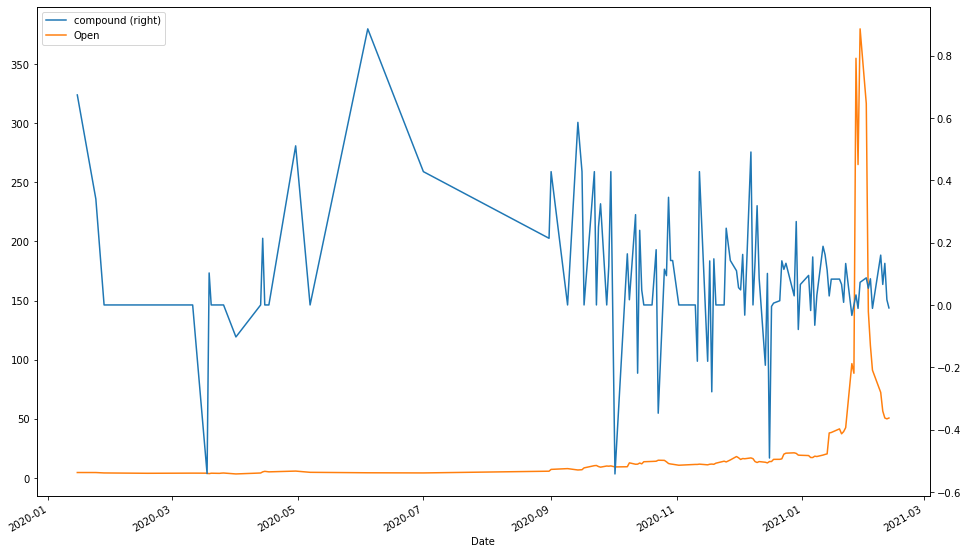

In [140]:


df_GME_wsb = get_market_data('GME',df_GME_scores,'2020-01-01',drop_NaN=True)

df = df_GME_wsb[['compound','Open']]



df.plot(secondary_y='compound', figsize=(16, 10));
# there seems to be no correlation at all, we will still attempt to put it in the model to see if it adds
# any predictive value

## Train Test Split

In [148]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

dataset = df_GME_wsb.values

# Set the X without Open or Date
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) # open price

#X = (dataset[:, 1:6])
#y = (dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



## LSTM

In [142]:
# Create LSTM trained on sentiment analysis data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()



model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train_scale, y_train, epochs = 225, batch_size = 32,
                         validation_split=0.1)

Epoch 1/225
3/3 [==============================] - 8s 763ms/step - loss: 3.8325e-04 - val_loss: 6.9230e-04
Epoch 2/225
3/3 [==============================] - 0s 19ms/step - loss: 3.5111e-04 - val_loss: 0.0012
Epoch 3/225
3/3 [==============================] - 0s 19ms/step - loss: 1.5402e-04 - val_loss: 0.0018
Epoch 4/225
3/3 [==============================] - 0s 18ms/step - loss: 2.1869e-04 - val_loss: 0.0016
Epoch 5/225
3/3 [==============================] - 0s 17ms/step - loss: 1.5813e-04 - val_loss: 0.0012
Epoch 6/225
3/3 [==============================] - 0s 15ms/step - loss: 1.8846e-04 - val_loss: 0.0010
Epoch 7/225
3/3 [==============================] - 0s 14ms/step - loss: 2.0145e-04 - val_loss: 0.0012

Root mean square error is 0.3490079418892754


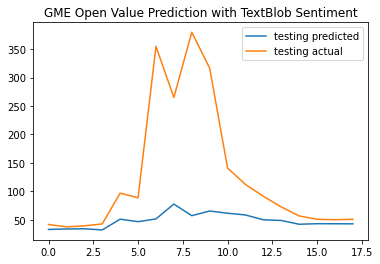

In [143]:
from sklearn.metrics import mean_squared_error

predicted_stock_GME = model.predict(X_test_scale)

testScore = np.sqrt(mean_squared_error(y_test[:], predicted_stock_GME[:,0]))

print('Root mean square error is {}'.format(testScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_GME),label='testing predicted')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('GME Open Value Prediction with TextBlob Sentiment')
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error is 0.003944123661782028


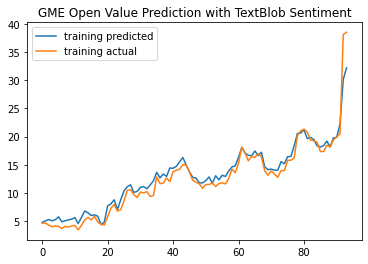

In [144]:
predicted_stock_GME_train = model.predict(X_train_scale)

trainScore = np.sqrt(mean_squared_error(y_train[:], predicted_stock_GME_train[:,0]))

print('Root mean square error is {}'.format(trainScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_GME_train),label='training predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('GME Open Value Prediction with TextBlob Sentiment')
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

## LSTM Without Sentiment Input

In [149]:
# Test the model without sentiment

# Set the X without Open or Date
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-1])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Create LSTM trained on sentiment analysis data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()



model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train_scale, y_train, epochs = 225, batch_size = 32,
                         validation_split=0.1)

Epoch 1/225
3/3 [==============================] - 12s 627ms/step - loss: 4.0993e-04 - val_loss: 8.4144e-04
Epoch 2/225
3/3 [==============================] - 0s 21ms/step - loss: 3.0066e-04 - val_loss: 0.0010
Epoch 3/225
3/3 [==============================] - 0s 17ms/step - loss: 1.7952e-04 - val_loss: 0.0017
Epoch 4/225
3/3 [==============================] - 0s 17ms/step - loss: 1.7602e-04 - val_loss: 0.0018
Epoch 5/225
3/3 [==============================] - 0s 15ms/step - loss: 2.3507e-04 - val_loss: 0.0015
Epoch 6/225
3/3 [==============================] - 0s 27ms/step - loss: 1.7614e-04 - val_loss: 0.0012
Epoch 7/225
3/3 [==============================] - 0s 15ms/step - loss: 1.7097e-04 - val_loss: 0.0012

Root mean square error is 0.24235412549242577


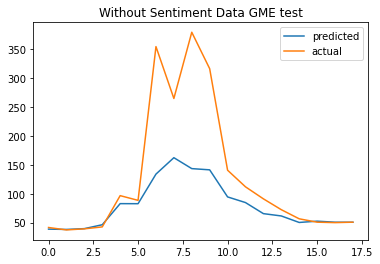

In [146]:
predicted_stock_GME = model.predict(X_test_scale)

testScore = np.sqrt(mean_squared_error(y_test[:], predicted_stock_GME[:,0]))

print('Root mean square error is {}'.format(testScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_GME),label='predicted')
plt.plot(y_MinMax.inverse_transform(y_test),label='actual')
plt.legend()
plt.title('Without Sentiment Data GME test')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error is 0.0021795719945760495


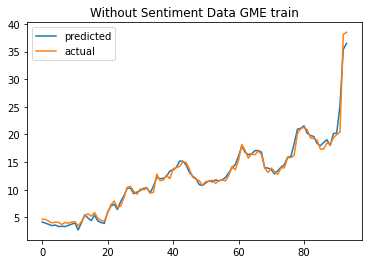

In [147]:
predicted_stock_GME_train = model.predict(X_train_scale)

trainScore = np.sqrt(mean_squared_error(y_train[:], predicted_stock_GME_train[:,0]))

print('Root mean square error is {}'.format(trainScore))

plt.plot(y_MinMax.inverse_transform(predicted_stock_GME_train),label='predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='actual')
plt.legend()
plt.title('Without Sentiment Data GME train')
plt.show()
plt.clf()
plt.cla()
plt.close()